In [2]:
import pandas as pd
from bertopic import BERTopic
import json
import openai
from transformers import pipeline

/projectnb/sparkgrp/dyxu/env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projectnb/sparkgrp/dyxu/env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projectnb/sparkgrp/dyxu/env/lib/python3.10/site-packages/umap/distances.py:1086: 

In [4]:
# load saved BERTopic Model, generate topics based on random 100k sample of the BostonGlobe (lexisnexis) data
topic_model = BERTopic.load("./bglobe_519_body") # for the scc: /projectnb/sparkgrp/mvoong/bglobe_519_body

In [5]:
# topic -1 are all outliers
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,57205,-1_says_public_town_court,"[says, public, town, court, department, years,...","[he dates first out of pity and then — oh, you..."
1,0,14317,0_wham_downtime_blah_salute,"[wham, downtime, blah, salute, ok, smiling, ac...","[, , ]"
2,1,12149,1_celtics_inning_red_league,"[celtics, inning, red, league, play, hits, coa...","[ For years, Cashman has had to endure the pa..."
3,2,6975,2_patriots_coach_defensive_bowl,"[patriots, coach, defensive, bowl, receiver, t...",[The Browns (2-10) lost for the second time in...
4,3,5460,3_album_fm_symphony_chs,"[album, fm, symphony, chs, www, blues, pop, ba...",[That the coming of the Hard Rock Cafe to Bost...
...,...,...,...,...,...
95,94,54,94_graduate_lackland_acelwell2_fort,"[graduate, lackland, acelwell2, fort, private,...","[Army Specialist Oscar Plaza, son of Eneida Ba..."
96,95,52,95_mach3_schick_kilts_sensor,"[mach3, schick, kilts, sensor, mockler, quattr...",[ Besides all the ways Gillette's product lin...
97,96,51,96_pentagon_budget_f414_ruegg,"[pentagon, budget, f414, ruegg, fighter, outla...","[Sen. John Warner of Virginia, the ranking Rep..."
98,97,51,97_hospice_assisted_linky_kevorkian,"[hospice, assisted, linky, kevorkian, pain, th...","[Among other worries, the court listed its fea..."


In [6]:
# see the articles
news_sample = pd.read_csv("./large_gbh_sample.csv") # for the scc: /projectnb/sparkgrp/mvoong/bglobe_100k_sample.csv
news_sample.head(10)

,Unnamed: 0,Tagging,Body_x
0,0,0000016a-3bcb-d661-af7b-7bff0d200001,The above is a continuous stream. <br/><br/>I...
1,1,0000016a-f0d5-dbfd-a56f-f4dfc34c0001,Click above for the audio of a special segment...
2,2,0000016b-539d-d757-adef-f7bd4a5f0001,"In honor of Father&#39;s Day, this segment of ..."
3,3,0000016f-c48a-d14c-a57f-e59b02310001,Robert Burns is known as &quot;Scotland&#39;s ...
4,4,00000170-273a-d4d2-a378-677e83f60001,"Folk music generally, and Celtic music, in par..."
5,5,00000170-97d9-d92c-a57c-ffdfc37d0001,"Its March, the &quot;high-holidays&quot; for I..."
6,6,00000170-ab96-d92c-a57c-ef9f69ab0001,"Its March, the &quot;high-holidays&quot; for I..."
7,7,00000171-98d6-d780-a77d-9bdecf820000,A video posted on TikTok by a 26-year-old Scot...
8,8,00000175-47fb-d94e-a9f7-c7fbdc120001,We don’t often train our view on the child act...
9,9,00000175-5752-d898-a775-d75f438f0001,"<i>Every season, the </i>Drama After Dark<i> t..."


In [7]:
# get docs for bert topic model - article body 
body = news_sample['Body_x']
topic_model.get_document_info(body)[:5]

ValueError: array length 163734 does not match index length 12680

In [6]:
def get_relevant_indexing_terms(sample):
    # cleaning sample data, add topic column  
    # get list of possible topic labels from the indexing terms (lexisnexis labels)
    # there's probably a much better way of doing this...
    # to do: also if there is more than one label - they should be ranked for evaluating openai label   
    possible_topics = []
    for terms in sample['indexing_terms']:
        temp = []
        try:
            terms = eval(terms)
            if terms['subject']:
                for v in terms['subject']:
                    if int(v['score']) > 85:
                        temp.append(v['className'])
            elif terms['industry']:
                for v in terms['industry']:
                    if int(v['industry']['score']) > 85:
                        temp.append(v['className'])
            elif terms['legal']:
                for v in terms['legal']:
                    temp.append(v['className'])
            possible_topics.append(temp)
        except KeyError:
            # no subjects, industry, or legal at all or above 85 
            possible_topics.append("") 
        except TypeError:
            # no indexing_terms 
            possible_topics.append("")
    return possible_topics

In [12]:
# add possible topics as new column in dataframe
bglobe_sample['possible_topics'] = get_relevant_indexing_terms(bglobe_sample)
bglobe_sample.head()

NameError: name 'bglobe_sample' is not defined

In [6]:
# get the bag of words (keywords) for each topic from the bertopic model
topics_df = topic_model.get_topic_info()
word_bags = [""]
for i in range(len(topics_df)):
    temp = topic_model.get_topic(i)
    try:
        words = [x for x,_ in temp]
        word_bags.append(words)
    except TypeError:
        pass

topics_df["Keywords"] = word_bags

In [7]:
# use openai api to create a label for the bag of words from bertopic


# exponential back off - because i kept getting ratelimiterror 
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return openai.ChatCompletion.create(**kwargs)

In [9]:
# get labels for all bag of words from bertopic
for i in range(1,len(topics_df)):
    labels = topics_df['Keywords'][i]
    
    # build prompt for openai 
    formatted_keywords = ", ".join(labels[:-1]) + ", and " + labels[-1] + ".\n"
    text_input = "Please summarize this list of words into three terms: " + formatted_keywords
    text_input += "Please generalize the final result.\n"

    # using gpt-3.5-turbo: $0.002/1,000 tokens
    # each request is ~150 tokens (including the response from openai)
    background_prompt = [{"role": "system", "content": "You are summarizing a list of words. Be as concise and informative as possible."},
                         {"role": "user", "content": "Please summarize this list of words into one term: covid, deaths, confirmed, baker, average, numbers, hospitals, dph, weeks, clusters. Please generalize the final result."},
                         {"role": "assistant", "content": "Public Health, Epidemia, Statistics"}]


    prompt = background_prompt + [{"role": "user", "content": text_input}]

    response = completion_with_backoff(model="gpt-3.5-turbo",
                                       temperature=1, 
                                       max_tokens=7,
                                       messages=prompt)

    # save result in json file
    with open('openai_label_gbh_13k.json', 'r+') as f:
        # load existing data 
        file_data = json.load(f)
        file_data[int(topics_df['Topic'][i])] = {"Name": topics_df['Name'][i],
                                              "OpenAI_label": response['choices'][0]['message']['content'],
                                              "OpenAI_metadata": response}
    
        f.seek(0)
        # convert back to json
        json.dump(file_data, f, indent=4)

In [10]:
# combine articles with topic labels from open ai 
f = open('improve_model/openai_label_gbh_13k.json')
openai_labels = json.load(f)

# add topic number from bertopic to bglobe dataframe in new column
news_sample['bertopic_topic_label'] = topic_model.get_document_info(body)['Topic']

# add open ai label to bglobe dataframe in new column    
label_name = [openai_labels[str(news_sample['bertopic_topic_label'][i])]['OpenAI_label'] 
              if int(news_sample['bertopic_topic_label'][i]) != -1 else "" for i in range(len(news_sample))]
news_sample['openai_label'] = label_name


In [11]:
labels_column = news_sample['openai_label']

# Split the keywords column into separate columns
split_columns = labels_column.str.split(',', expand=True)

# Rename the columns with appropriate names
new_columns = [f'Keyword_{i+1}' for i in range(split_columns.shape[1])]
split_columns.columns = new_columns

# Fill empty cells with NaN
split_columns = split_columns.replace('', pd.NA)

# Concatenate the original DataFrame with the split columns
news_sample = pd.concat([news_sample, split_columns], axis=1)

news_sample.drop(columns=['openai_label'], inplace=True)

news_sample.head(10)

,Unnamed: 0,Tagging,Body_x,bertopic_topic_label,Keyword_1,Keyword_2,Keyword_3
0,2732,00000178-242a-d76c-a77b-667bfef80001,"As more people get shots, hesitancy toward COV...",2,COVID-19 Vaccines: Boost,None,None
1,7357,0000017e-b5f9-d8d4-a5ff-fdfdde050002,The coronavirus vaccine mandate implemented in...,17,Vaccine Requirements and Exemptions,None,None
2,5109,0000017b-2a91-d289-ab7b-fa93d5270001,Norwegian Cruise Line can require passengers s...,-1,<NA>,None,None
3,743,00000176-28e7-d45d-a377-3aff27410001,As hospitals across the country weather a surg...,16,Pandemic Response: Healthcare Resources,None,None
4,3708,00000179-43c9-de59-a579-cfe9163f0001,Mikayla Miller loved to write. She had dreams ...,156,Conflict,Investigation,Fatalities
5,929,00000176-57e5-d762-ad7f-77ed2fd30001,"For weeks, President Trump's push to overturn ...",52,Election,Legal Challenge,Outcome
6,3561,00000179-1497-ddcd-a57f-fdff5ec70001,Massachusetts Attorney General Maura Healey re...,17,Vaccine Requirements and Exemptions,None,None
7,12661,00000187-3337-da17-afc7-f37f37ad0001,"<i>For more than a century, Dr. James Marion S...",-1,<NA>,None,None
8,5646,0000017b-fa47-d9cf-a9ff-faf7a6370001,<i>The Queen's Gambit</i> on Netflix won over ...,-1,<NA>,None,None
9,7299,0000017e-9e3d-d578-a77e-9e7d1dbe0001,With just under 100 days until federal student...,49,Agriculture,Student Loan Forg,None


In [23]:
news_sample.drop(columns=['Keyword_1', 'Keyword_2', 'Keyword_3', 'Keyword_4'], inplace=True)

In [12]:
json_sample = pd.read_csv("geocoded_articles.csv")
json_sample.dropna
json_sample['Tagging'] = json_sample['content_id']
json_sample.drop(columns='content_id', inplace=True)
# Merge the larger DataFrame with the subset DataFrame based on the 'unique_id' column
merged_df = pd.merge(json_sample, news_sample[['Tagging', 'Keyword_1', 'Keyword_2', 'Keyword_3']], on='Tagging', how='left')

# Check if the 'label' column exists in the merged DataFrame
if 'label' in merged_df.columns:
    # Remove the existing 'label' column from the subset DataFrame
    json_sample.drop(columns=['Keyword_1', 'Keyword_2', 'Keyword_3'], inplace=True)

# Append the 'label' column from the merged DataFrame to the subset DataFrame
json_sample = pd.concat([json_sample, merged_df[['Keyword_1', 'Keyword_2', 'Keyword_3']]], axis=1)

In [13]:
json_sample = json_sample.dropna(subset=['body'])
json_sample.to_csv("gbh_step_one_output.csv")

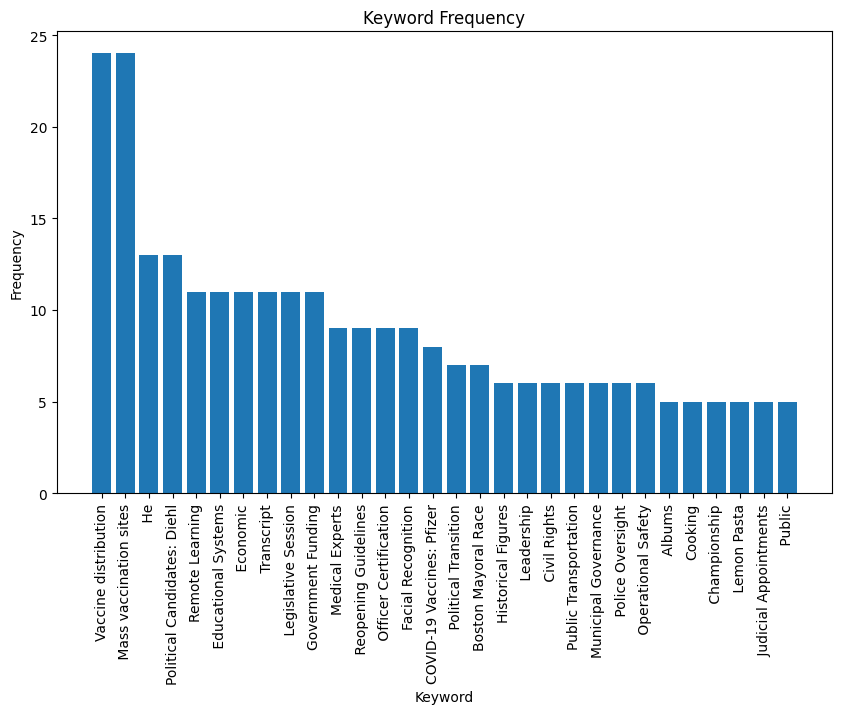

In [13]:
import matplotlib.pyplot as plt

# Creating a bar chart of all keywords
keyword_columns = ['Keyword_1', 'Keyword_2', 'Keyword_3', 'Keyword_4']

# Concatenate all keyword columns into a single Series
all_keywords = pd.concat([json_sample[column] for column in keyword_columns]).dropna()

# Compute the frequency of each keyword
keyword_counts = all_keywords.value_counts().nlargest(30)

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as per your preference
plt.bar(keyword_counts.index, keyword_counts.values)

# Set labels and title
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.title('Keyword Frequency')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Show the bar chart
plt.show()

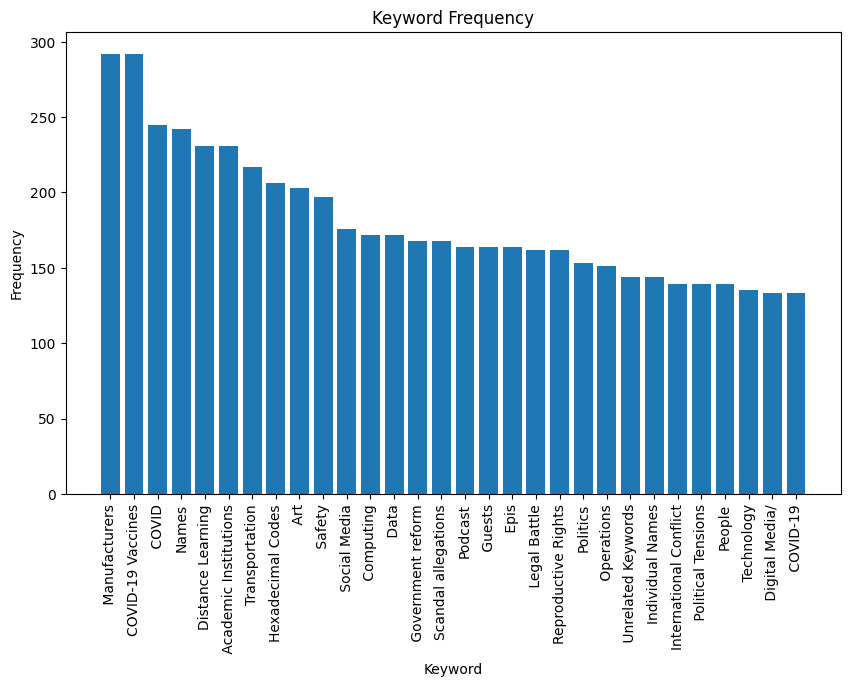

In [14]:
import matplotlib.pyplot as plt

# Creating a bar chart of all keywords
keyword_columns = ['Keyword_1', 'Keyword_2', 'Keyword_3']

# Concatenate all keyword columns into a single Series
all_keywords = pd.concat([news_sample[column] for column in keyword_columns]).dropna()

# Compute the frequency of each keyword
keyword_counts = all_keywords.value_counts().nlargest(30)

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as per your preference
plt.bar(keyword_counts.index, keyword_counts.values)

# Set labels and title
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.title('Keyword Frequency')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Show the bar chart
plt.show()

In [19]:
news_sample[:200].to_csv("sample_for_human_evaluation.csv",columns=['Body_x', 'Keyword_1', 'Keyword_2', 'Keyword_3', 'Keyword_4'])
news_sample.describe

<bound method NDFrame.describe of        Unnamed: 0                               Tagging  \
0            2732  00000178-242a-d76c-a77b-667bfef80001   
1            7357  0000017e-b5f9-d8d4-a5ff-fdfdde050002   
2            5109  0000017b-2a91-d289-ab7b-fa93d5270001   
3             743  00000176-28e7-d45d-a377-3aff27410001   
4            3708  00000179-43c9-de59-a579-cfe9163f0001   
...           ...                                   ...   
10139        3724  00000179-4bd9-df8c-ad7d-dbdb51700001   
10140        9254  00000181-9581-d0e3-afe1-f7e7014e0001   
10141        6814  0000017d-d93f-d91e-a3fd-ddff81fd0001   
10142        3586  00000179-1acd-de59-a579-dfedceb40001   
10143        1554  00000176-fd41-d79b-abfe-fdf7833e0001   

                                                  Body_x  \
0      As more people get shots, hesitancy toward COV...   
1      The coronavirus vaccine mandate implemented in...   
2      Norwegian Cruise Line can require passengers s...   
3      As hospita

In [18]:
# use boston_herald_test.csv to assign bertopic labels and test the openai labels 
# get the relevant lexisnexis indexing terms
test_articles = pd.read_csv("boston_herald_test.csv")
test_articles['possible_topics'] = get_relevant_indexing_terms(test_articles)

FileNotFoundError: [Errno 2] No such file or directory: 'boston_herald_test.csv'

In [114]:
# replace nan body with ""
for i in range(len(test_articles)):
    if type(test_articles['body'][i]) != str:
        test_articles['body'][i] = ""


In [ ]:
# get bertopics for each article
topics, probs = topic_model.transform(test_articles['body'])
test_articles['bertopic_topic_label'] = topics

# add open ai label to bglobe dataframe in new column    
test_label_name = [openai_labels[str(test_articles['bertopic_topic_label'][i])]['OpenAI_label'] 
              if int(test_articles['bertopic_topic_label'][i]) != -1 else "" for i in range(len(test_articles))]
test_articles['openai_label'] = test_label_name

In [132]:
test_articles

,pub_type,position_section,position_subsection,hl1,hl2,author,lede,body,language,word_count,...,issue_number,edition,pub_name,pub_date,licensor_indexing_terms,indexing_terms,possible_topics,bertopic_topic_label\t,bertopic_topic_label,openai_label
0,"Newspaper, Newspapers",NEWS,Local,3-alarm blaze leaves some homeless,NaN,COLNETH SMILEY Jr.,A three-alarm blaze at a Quincy apartment buil...,Smoke from the fire on Newport Street across f...,['ENGLISH'],158,...,No. 309,All Editions,The Boston Herald,5/11/15,"FIRE, NEWPORT, QUINCY, ALARM, SMOKE, SMYTH, 30...","{'legal': [{'className': 'Governments', 'class...",[FIRES],16,16,Fire Safety
1,"Newspaper, Newspapers",NEWS,Local,Bridgewater police seek ID of burned woman's body,NaN,BRIAN DOWLING,Police are asking for the public's help to ide...,"The remains of the unidentified woman, whose h...",['ENGLISH'],201,...,No. 309,All Editions,The Boston Herald,5/11/15,"WOMAN, POLICE, BODY, BRIDGEWATER, BURNED, CRUZ...","{'subject': [{'score': '90', 'classCode': 'N92...",[POLICE FORCES],-1,-1,
2,"Newspaper, Newspapers",SPORTS,Football-NFL,Fitzpatrick gets thumbs-up to start,NaN,NaN,It's a thumbs-up on Ryan Fitzpatrick starting ...,"'No limitations today,' Fitzpatrick said. 'Rea...",['ENGLISH'],514,...,No. 309,All Editions,The Boston Herald,5/11/15,"FITZPATRICK, MANZIEL, COACH, FISHER, QUARTERBA...","{'legal': [{'className': 'Education Law', 'cla...","[ATHLETES, AMERICAN FOOTBALL]",-1,2,Football.
3,"Newspaper, Newspapers",NEWS,Obituaries,"Eileen Walsh, at 83, - of Abington, a nurse",NaN,NaN,"Eileen (Conlon) Walsh of Abington, a nurse, di...",She was a nurse at Shattuck and Carney hospita...,['ENGLISH'],111,...,No. 309,All Editions,The Boston Herald,5/11/15,"NURSE, WALSH, ABINGTON, EILEEN, FUNERAL, ARRAN...","{'subject': [{'score': '97', 'classCode': 'STX...",[DEATHS & OBITUARIES],4,4,Personal Life/Obit
4,"Newspaper, Newspapers",SPORTS,Agate,HIGH SCHOOL SCOREBOARD,NaN,NaN,"FIELD HOCKEY Governor's 5, Groton 1 St. Mark's...","Newton North at Needham, 4 Chelmsford at North...",['ENGLISH'],937,...,No. 309,All Editions,The Boston Herald,5/11/15,"BISHOP, CATHOLIC, CENTRAL, DIVISION, NORTH, PR...","{'subject': [{'score': '89', 'classCode': 'ST0...",[CATHOLICS & CATHOLICISM],436,436,Prep Schools.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,"Newspaper, Newspapers",NEWS,Local,Women make history in Hub and the state,NaN,Joyce Ferriabough Bolling,The post-election story in the media was how t...,But there was another important story: Boston'...,['ENGLISH'],444,...,No. 309,All Editions,The Boston Herald,5/11/15,"WOMEN, ELECTED, COLOR, COUNCIL, WOMAN, BOSTON,...","{'legal': [{'className': 'Governments', 'class...","[CITY GOVERNMENT, CITIES, WOMEN, Local Governm...",-1,-1,
88,"Newspaper, Newspapers",OPINION,Editorials,A mayor in reverse,NaN,NaN,Boston Mayor Marty Walsh has learned the hard ...,"Walsh, the city's top cheerleader for a planne...",['ENGLISH'],337,...,No. 309,All Editions,The Boston Herald,5/11/15,"AGREEMENT, BOSTON, EDITOR, EVENT, LEARNED, MAY...","{'legal': [{'className': 'Governments', 'class...","[AGREEMENTS, CITY GOVERNMENT, Mayors]",137,137,Olympic Hosting Bid
89,"Newspaper, Newspapers",NEWS,Local,Fentanyl OD data lagging - in Bay State,NaN,MATT STOUT,As the tide of fentanyl grows in Massachusetts...,The information gap comes as federal officials...,['ENGLISH'],491,...,No. 309,All Editions,The Boston Herald,5/11/15,"FENTANYL, OFFICIALS, STATE, RELATED, DATA, HEA...","{'subject': [{'score': '89', 'classCode': 'ST0...","[HEALTH DEPARTMENTS, HEROIN, PUBLIC HEALTH ADM...",55,55,Opioid Crisis
90,"Newspaper, Newspapers",SPORTS,Basketball-Celtics,Slow start angers Celts,In need of quick fix after falling to 1-3,STEVE BULPETT,INDIANAPOLIS - The Celtics have dropped three ...,'Something's got to change. I don't know what ...,['ENGLISH'],899,...,No. 309,All Editions,The Boston Herald,5/11/15,"CELTICS, CELTS, BRADLEY, DIDN, GAMES, PACERS, ...",{'legal': [{'cl

In [133]:
# remove articles with bertopic label -1 - these are outliers that don't have a label 
# to do: look into if it is possible to use bertopic to assign a label to the outliers anyways 

# for now - we will look at articles that have a label other than -1 
test_articles_labeled = test_articles[test_articles['bertopic_topic_label'] != -1]

# evaluate the similarity between words from lexis nexis and openai label 
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
sequence_to_classify = test_articles_labeled['openai_label'][0]
candidate_labels = test_articles_labeled['possible_topics'][0]
classifier(sequence_to_classify, candidate_labels, multi_class=True)

The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


{'sequence': 'Fire Safety',
 'labels': ['FIRES'],
 'scores': [0.8304260969161987]}

In [134]:
# attempt at evaluation using bart-mnli zero shot classification 
# get the max score from the candidate labels (lexisnexis labels) compared to the openai label
scores = []
for id, row in test_articles.iterrows():
    try:
        sequence_to_classify = row['openai_label']
        candidate_labels = row['possible_topics']
        result = classifier(sequence_to_classify, candidate_labels, multi_label=True)
        max_score = max(result['scores'])
        scores.append(max_score)
    except ValueError:
        scores.append("")

In [137]:
# add the scores to the test_articles dataframe
test_articles['eval_score'] = scores

In [139]:
test_articles.to_csv("eval_output.csv")

In [ ]:
# to do - lower threshold for indexing terms if there are none that are above 85 